In [151]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import os

import sys
sys.path.append("..")

from channeling_lib import AWS_file_loader, load_path

stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']

load data

In [152]:
path = load_path()+'RawData/AWS/'
instrument_textbook_name = load_path()+'instrument_textbook_BLcourse_spring2025(BL instruments).csv'

instrument_textbook_data = pd.read_csv(instrument_textbook_name, encoding='latin1')

# instrument_textbook_data['Maintenance duration (minutes)'] == 'Layla'

In [153]:
#station data raw
#layla all
raw_layla_20250130 = path + 'Layla/CR1000_Layla_Res_data_1_min_20240910_20250130_2025_01_30_09_54_45.dat'
raw_layla_20250203 = path + 'Layla/CR1000_Layla_Res_data_1_min_20240910_20250203_2025_02_03_11_19_37.dat'

#rosanna all
raw_rosanna_20250131 =  path + 'Rosanna/CR200_Rosanna_Res_data_1_min_20240910_20250131_2025_01_31_11_09_07.dat'
raw_rosanna_20250203 =  path + 'Rosanna/CR200_Rosanna_Res_data_1_min_20240910_20250203_2025_02_03_09_23_11.dat'

#mrs robinson all
raw_mrsrobinson_20250131 =  path + 'Mrs Robinson/CR200_MrsRobinson_Res_data_1_min_20240910_20250131_2025_01_31_16_10_22.dat'
raw_mrsrobinson_20250203 =  path + 'Mrs Robinson/CR200_MrsRobinson_Res_data_1_min_20240910_20250203_2025_02_03_10_44_29.dat'

#bette davis all
raw_bettedavis_20250131 =  path + 'Bette Davis/CR200_BetteDavis_Res_data_1_min_20240910_20250131_2025_01_31_13_20_02.dat'
raw_bettedavis_20250203 =  path + 'Bette Davis/CR200_BetteDavis_Res_data_1_min_20240910_20250203_2025_02_03_10_00_51.dat'

#Tom joad all
raw_tomjoad_20250130 =  path + 'Tom Joad/CR1000_TomJoad_Res_data_1_min_20240910_20250130_2025_01_30_11_01_43.dat'
raw_tomjoad_20250203 =  path + 'Tom Joad/CR1000_TomJoad_Res_data_1_min_20240910_20250203_2025_02_03_13_46_13.dat'

slice

In [154]:
manual_times = {}


stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']
for station in stations_str:
    setup_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Station name'] == station, 'Setup time (UTC)'].values[0])

    maintenance_start_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Station name'] == station, 'Maintenance start time (UTC)'].values[0])

    maintenance_duration_idx = int(instrument_textbook_data.loc[instrument_textbook_data['Station name'] == station, 'Maintenance duration (minutes)'].values[0])

    retrieval_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Station name'] == station, 'Retrieval time (UTC)'].values[0])

    manual_times[station] = {
            'setup_time': setup_time_idx,
            'maintenance_start_time': maintenance_start_time_idx,
            'maintenance_duration': maintenance_duration_idx,
            'retrieval_time': retrieval_time_idx
        }

In [155]:
# #values from excel sheet
# manual_times = {
#     "Layla": {
#         "setup_time": pd.to_datetime("2025-01-26 11:30:00"),
#         "maintenance_start_time": pd.to_datetime("2025-01-28 09:35:00"),
#         "maintenance_duration": 1,  # Minuten
#         "retrieval_time": pd.to_datetime("2025-02-03 11:05:00")
#     },
#     "Rosanna": {
#         "setup_time": pd.to_datetime("2025-01-27 10:35:00"),
#         "maintenance_start_time": pd.to_datetime("2025-01-31 10:45:00"),
#         "maintenance_duration": 50,  # Minuten
#         "retrieval_time": pd.to_datetime("2025-02-03 09:05:00")
#     },
#     "Mrs Robinson": {
#         "setup_time": pd.to_datetime("2025-01-27 13:45:00"),
#         "maintenance_start_time": pd.to_datetime("2025-01-31 15:55:00"),
#         "maintenance_duration": 40,  # Minuten
#         "retrieval_time": pd.to_datetime("2025-02-03 10:32:00")
#     },
#     "Bette Davis": {
#         "setup_time": pd.to_datetime("2025-01-27 12:15:00"),
#         "maintenance_start_time": pd.to_datetime("2025-01-31 13:00:00"),
#         "maintenance_duration": 63,  # Minuten
#         "retrieval_time": pd.to_datetime("2025-02-03 09:47:00")
#     },
#     "Tom Joad": {
#         "setup_time": pd.to_datetime("2025-01-26 14:35:00"),
#         "maintenance_start_time": pd.to_datetime("2025-01-28 10:45:00"),
#         "maintenance_duration": 25,  # Minuten
#         "retrieval_time": pd.to_datetime("2025-02-03 12:09:00")
#     }
# }

# manual_times


In [156]:
def filter_data_based_on_time(df, setup_time, maintenance_start_time, maintenance_duration, retrieval_time, is_second_file=False):
    """
    Filtert die Daten basierend auf den angegebenen Zeitbereichen für das 1. und 2. Dataset.
    
    :param df: Der DataFrame mit den Rohdaten.
    :param setup_time: Der Setup-Zeitpunkt in UTC (als pd.Timestamp).
    :param maintenance_start_time: Der Startzeitpunkt der Wartung in UTC (als pd.Timestamp).
    :param maintenance_duration: Die Dauer der Wartung in Minuten.
    :param retrieval_time: Der Retrieval-Zeitpunkt in UTC (als pd.Timestamp).
    :param is_second_file: True, wenn es sich um das 2. Dataset handelt, andernfalls False für das 1. Dataset.
    :return: Der gefilterte DataFrame.
    """
    if is_second_file:
        # Filter für das 2. Dataset: nach Maintenance start time + duration + 5 Minuten und Retrieval time - 5 Minuten
        start_time = maintenance_start_time + pd.Timedelta(minutes=int(maintenance_duration))
        end_time = retrieval_time
    else:
        # Filter für das 1. Dataset: nach Setup time + 5 Minuten und Maintenance start time - 5 Minuten
        start_time = setup_time
        end_time = maintenance_start_time

    # Filter die Daten innerhalb des angegebenen Zeitrahmens
    filtered_df = df[(df.index >= start_time) & (df.index <= end_time)]
    return filtered_df


In [157]:
# Layla - File 1 und File 2
raw_data_1_layla = AWS_file_loader(raw_layla_20250130)
raw_data_2_layla = AWS_file_loader(raw_layla_20250203)
layla_times = manual_times["Layla"]
filtered_data_1_layla = filter_data_based_on_time(
    raw_data_1_layla, 
    layla_times["setup_time"], 
    layla_times["maintenance_start_time"], 
    layla_times["maintenance_duration"], 
    layla_times["retrieval_time"], 
    is_second_file=False
)
filtered_data_2_layla = filter_data_based_on_time(
    raw_data_2_layla, 
    layla_times["setup_time"], 
    layla_times["maintenance_start_time"], 
    layla_times["maintenance_duration"], 
    layla_times["retrieval_time"], 
    is_second_file=True
)

# Rosanna - File 1 und File 2
raw_data_1_rosanna = AWS_file_loader(raw_rosanna_20250131)
raw_data_2_rosanna = AWS_file_loader(raw_rosanna_20250203)
rosanna_times = manual_times["Rosanna"]
filtered_data_1_rosanna = filter_data_based_on_time(
    raw_data_1_rosanna, 
    rosanna_times["setup_time"], 
    rosanna_times["maintenance_start_time"], 
    rosanna_times["maintenance_duration"], 
    rosanna_times["retrieval_time"], 
    is_second_file=False
)
filtered_data_2_rosanna = filter_data_based_on_time(
    raw_data_2_rosanna, 
    rosanna_times["setup_time"], 
    rosanna_times["maintenance_start_time"], 
    rosanna_times["maintenance_duration"], 
    rosanna_times["retrieval_time"], 
    is_second_file=True
)

# Mrs Robinson - File 1 und File 2
raw_data_1_mrsrobinson = AWS_file_loader(raw_mrsrobinson_20250131)
raw_data_2_mrsrobinson = AWS_file_loader(raw_mrsrobinson_20250203)
mrsrobinson_times = manual_times["Mrs Robinson"]
filtered_data_1_mrsrobinson = filter_data_based_on_time(
    raw_data_1_mrsrobinson, 
    mrsrobinson_times["setup_time"], 
    mrsrobinson_times["maintenance_start_time"], 
    mrsrobinson_times["maintenance_duration"], 
    mrsrobinson_times["retrieval_time"], 
    is_second_file=False
)
filtered_data_2_mrsrobinson = filter_data_based_on_time(
    raw_data_2_mrsrobinson, 
    mrsrobinson_times["setup_time"], 
    mrsrobinson_times["maintenance_start_time"], 
    mrsrobinson_times["maintenance_duration"], 
    mrsrobinson_times["retrieval_time"], 
    is_second_file=True
)

# Bette Davis - File 1 und File 2
raw_data_1_bettedavis = AWS_file_loader(raw_bettedavis_20250131)
raw_data_2_bettedavis = AWS_file_loader(raw_bettedavis_20250203)
bettedavis_times = manual_times["Bette Davis"]
filtered_data_1_bettedavis = filter_data_based_on_time(
    raw_data_1_bettedavis, 
    bettedavis_times["setup_time"], 
    bettedavis_times["maintenance_start_time"], 
    bettedavis_times["maintenance_duration"], 
    bettedavis_times["retrieval_time"], 
    is_second_file=False
)
filtered_data_2_bettedavis = filter_data_based_on_time(
    raw_data_2_bettedavis, 
    bettedavis_times["setup_time"], 
    bettedavis_times["maintenance_start_time"], 
    bettedavis_times["maintenance_duration"], 
    bettedavis_times["retrieval_time"], 
    is_second_file=True
)

# Tom Joad - File 1 und File 2
raw_data_1_tomjoad = AWS_file_loader(raw_tomjoad_20250130)
raw_data_2_tomjoad = AWS_file_loader(raw_tomjoad_20250203)
tomjoad_times = manual_times["Tom Joad"]
filtered_data_1_tomjoad = filter_data_based_on_time(
    raw_data_1_tomjoad, 
    tomjoad_times["setup_time"], 
    tomjoad_times["maintenance_start_time"], 
    tomjoad_times["maintenance_duration"], 
    tomjoad_times["retrieval_time"], 
    is_second_file=False
)
filtered_data_2_tomjoad = filter_data_based_on_time(
    raw_data_2_tomjoad, 
    tomjoad_times["setup_time"], 
    tomjoad_times["maintenance_start_time"], 
    tomjoad_times["maintenance_duration"], 
    tomjoad_times["retrieval_time"], 
    is_second_file=True
)

# Ausgabe der Ergebnisse
# print("Gefilterte Daten für Layla (File 1):")
# print(filtered_data_1_layla.head())
# print(f"Startdatum: {filtered_data_1_layla.index.min()} | Enddatum: {filtered_data_1_layla.index.max()}")

# print("Gefilterte Daten für Layla (File 2):")
# print(filtered_data_2_layla.head())
# print(f"Startdatum: {filtered_data_2_layla.index.min()} | Enddatum: {filtered_data_2_layla.index.max()}")
# Wiederhole dies für die anderen Stationen (Rosanna, Mrs Robinson, etc.)
#filtered_data_2_layla

c:\Users\Paula\anaconda3\envs\Boundary_Layer\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
c:\Users\Paula\anaconda3\envs\Boundary_Layer\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
c:\Users\Paula\anaconda3\envs\Boundary_Layer\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_object

filter for:\\
rel humidity: 0% --> 100%\\
wind direction: 0° --> 360°\\
wind speed: > 0m/s\\

In [158]:
def filter_humidity(df):
    df['rel_humidity'] = df['rel_humidity'].apply(lambda x: np.nan if x > 100 else x)
    return df


filtered_data_1_layla = filter_humidity(filtered_data_1_layla)
filtered_data_2_layla = filter_humidity(filtered_data_2_layla)

filtered_data_1_rosanna = filter_humidity(filtered_data_1_rosanna)
filtered_data_2_rosanna = filter_humidity(filtered_data_2_rosanna)

filtered_data_1_mrsrobinson = filter_humidity(filtered_data_1_mrsrobinson)
filtered_data_2_mrsrobinson = filter_humidity(filtered_data_2_mrsrobinson)

filtered_data_1_bettedavis = filter_humidity(filtered_data_1_bettedavis)
filtered_data_2_bettedavis = filter_humidity(filtered_data_2_bettedavis)

filtered_data_1_tomjoad = filter_humidity(filtered_data_1_tomjoad)
filtered_data_2_tomjoad = filter_humidity(filtered_data_2_tomjoad)


C:\Users\Paula\AppData\Local\Temp\ipykernel_14936\3275847226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rel_humidity'] = df['rel_humidity'].apply(lambda x: np.nan if x > 100 else x)


merge

In [159]:
layla_all_filtered = pd.concat((filtered_data_1_layla, filtered_data_2_layla))
rosanna_all_filtered = pd.concat((filtered_data_1_rosanna, filtered_data_2_rosanna))
mrsrobinson_all_filtered = pd.concat((filtered_data_1_mrsrobinson, filtered_data_2_mrsrobinson))
bettedavis_all_filtered = pd.concat((filtered_data_1_bettedavis, filtered_data_2_bettedavis))
tomjoad_all_filtered = pd.concat((filtered_data_1_tomjoad, filtered_data_2_tomjoad))

# layla_all_filtered

calibration

In [160]:
#wind
def calibrate_wind_speed_layla(wind_speed):
    if np.isnan(wind_speed):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_speed = wind_speed * 0.91 - 0.04
    return max(calibrated_speed, 0)  # Falls der Wert negativ ist, setze ihn auf 0

def calibrate_wind_speed_rosanna(wind_speed):
    if np.isnan(wind_speed):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_speed = wind_speed * 1.06 + 0.01
    return max(calibrated_speed, 0)

def calibrate_wind_speed_mrsrobinson(wind_speed):
    if np.isnan(wind_speed):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_speed = wind_speed * 1.06 - 0.05
    return max(calibrated_speed, 0)

def calibrate_wind_speed_bettedavis(wind_speed):
    if np.isnan(wind_speed):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_speed = wind_speed * 0.98 + 0.1
    return max(calibrated_speed, 0)

def calibrate_wind_speed_tomjoad(wind_speed):
    if np.isnan(wind_speed):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_speed = wind_speed * 1 - 0.03
    return max(calibrated_speed, 0)


In [161]:
#pressure
def calibrate_air_pressure_layla(air_pressure):
    if np.isnan(air_pressure):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_air_pressure = air_pressure * 0.99 + 6.04
    return max(calibrated_air_pressure, 0)  # Falls der Wert negativ ist, setze ihn auf 0

def calibrate_air_pressure_rosanna(air_pressure):
    if np.isnan(air_pressure):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_air_pressure = air_pressure * 1.01 - 6.04
    return max(calibrated_air_pressure, 0)

In [162]:
#relative humidity

def calibrate_rel_humidity_layla(rel_humidity):
    if np.isnan(rel_humidity):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_rel_humidity = rel_humidity * 1.01 + 5.25
    return max(calibrated_rel_humidity, 0)  # Falls der Wert negativ ist, setze ihn auf 0

def calibrate_rel_humidity_rosanna(rel_humidity):
    if np.isnan(rel_humidity):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_rel_humidity = rel_humidity * 1.08 - 11.78
    return max(calibrated_rel_humidity, 0)

def calibrate_rel_humidity_mrsrobinson(rel_humidity):
    if np.isnan(rel_humidity):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_rel_humidity = rel_humidity * 1.07 - 4.82
    return max(calibrated_rel_humidity, 0)

def calibrate_rel_humidity_bettedavis(rel_humidity):
    if np.isnan(rel_humidity):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_rel_humidity = rel_humidity * 0.99 + 0.48
    return max(calibrated_rel_humidity, 0)

def calibrate_rel_humidity_tomjoad(rel_humidity):
    if np.isnan(rel_humidity):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_rel_humidity = rel_humidity * 0.84 +11.04
    return max(calibrated_rel_humidity, 0)


In [163]:
# Temperature 

def calibrate_temperature_layla(temperature):
    if np.isnan(temperature):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_temperature = temperature * 1 + 0.42  # Beispielkalibrierung (Beispielwerte)
    return calibrated_temperature

def calibrate_temperature_rosanna(temperature):
    if np.isnan(temperature):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_temperature = temperature * 0.99 - 0.17  # Beispielkalibrierung (Beispielwerte)
    return calibrated_temperature

def calibrate_temperature_mrsrobinson(temperature):
    if np.isnan(temperature):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_temperature = temperature * 1 - 0.12  # Beispielkalibrierung (Beispielwerte)
    return calibrated_temperature

def calibrate_temperature_bettedavis(temperature):
    if np.isnan(temperature):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_temperature = temperature * 1 + 0.02  # Beispielkalibrierung (Beispielwerte)
    return calibrated_temperature

def calibrate_temperature_tomjoad(temperature):
    if np.isnan(temperature):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_temperature = temperature * 1.01 - 0.14  # Beispielkalibrierung (Beispielwerte)
    return calibrated_temperature


In [164]:
# Wind direction

def calibrate_wind_direction_layla(wind_direction):
    if np.isnan(wind_direction):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_wind_direction = wind_direction * 0.95 + 11.72  # Beispielkalibrierung (Beispielwerte)
    return calibrated_wind_direction

def calibrate_wind_direction_rosanna(wind_direction):
    if np.isnan(wind_direction):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_wind_direction = wind_direction * 1.03 + 0.62  # Beispielkalibrierung (Beispielwerte)
    return calibrated_wind_direction

def calibrate_wind_direction_mrsrobinson(wind_direction):
    if np.isnan(wind_direction):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_wind_direction = wind_direction * 1.12 - 19.18  # Beispielkalibrierung (Beispielwerte)
    return calibrated_wind_direction

def calibrate_wind_direction_bettedavis(wind_direction):
    if np.isnan(wind_direction):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_wind_direction = wind_direction * 0.99 + 14.76  # Beispielkalibrierung (Beispielwerte)
    return calibrated_wind_direction

def calibrate_wind_direction_tomjoad(wind_direction):
    if np.isnan(wind_direction):  # Überprüfen, ob der Wert NaN ist
        return np.nan
    calibrated_wind_direction = wind_direction * 0.9 + 6.48  # Beispielkalibrierung (Beispielwerte)
    return calibrated_wind_direction


In [165]:
# Schritt 1: Alle DataFrames zusammenführen
layla_all_filtered = pd.concat((filtered_data_1_layla, filtered_data_2_layla))
rosanna_all_filtered = pd.concat((filtered_data_1_rosanna, filtered_data_2_rosanna))
mrsrobinson_all_filtered = pd.concat((filtered_data_1_mrsrobinson, filtered_data_2_mrsrobinson))
bettedavis_all_filtered = pd.concat((filtered_data_1_bettedavis, filtered_data_2_bettedavis))
tomjoad_all_filtered = pd.concat((filtered_data_1_tomjoad, filtered_data_2_tomjoad))

# apply calibration wind_speed
layla_all_filtered['calibrated_wind_speed'] = layla_all_filtered['wind_speed'].apply(calibrate_wind_speed_layla)
rosanna_all_filtered['calibrated_wind_speed'] = rosanna_all_filtered['wind_speed'].apply(calibrate_wind_speed_rosanna)
mrsrobinson_all_filtered['calibrated_wind_speed'] = mrsrobinson_all_filtered['wind_speed'].apply(calibrate_wind_speed_mrsrobinson)
bettedavis_all_filtered['calibrated_wind_speed'] = bettedavis_all_filtered['wind_speed'].apply(calibrate_wind_speed_bettedavis)
tomjoad_all_filtered['calibrated_wind_speed'] = tomjoad_all_filtered['wind_speed'].apply(calibrate_wind_speed_tomjoad)

# apply calibration pressure
layla_all_filtered['calibrated_air_pressure'] = layla_all_filtered['air_pressure'].apply(calibrate_air_pressure_layla)
rosanna_all_filtered['calibrated_air_pressure'] = rosanna_all_filtered['air_pressure'].apply(calibrate_air_pressure_rosanna)

# apply calibration humidity
layla_all_filtered['calibrated_rel_humidity'] = layla_all_filtered['rel_humidity'].apply(calibrate_rel_humidity_layla)
rosanna_all_filtered['calibrated_rel_humidity'] = rosanna_all_filtered['rel_humidity'].apply(calibrate_rel_humidity_rosanna)
mrsrobinson_all_filtered['calibrated_rel_humidity'] = mrsrobinson_all_filtered['rel_humidity'].apply(calibrate_rel_humidity_mrsrobinson)
bettedavis_all_filtered['calibrated_rel_humidity'] = bettedavis_all_filtered['rel_humidity'].apply(calibrate_rel_humidity_bettedavis)
tomjoad_all_filtered['calibrated_rel_humidity'] = tomjoad_all_filtered['rel_humidity'].apply(calibrate_rel_humidity_tomjoad)

# apply calibration temperature
layla_all_filtered['temperature'] = layla_all_filtered['temperature'].apply(calibrate_temperature_layla)
rosanna_all_filtered['temperature'] = rosanna_all_filtered['temperature'].apply(calibrate_temperature_rosanna)
mrsrobinson_all_filtered['temperature'] = mrsrobinson_all_filtered['temperature'].apply(calibrate_temperature_mrsrobinson)
bettedavis_all_filtered['temperature'] = bettedavis_all_filtered['temperature'].apply(calibrate_temperature_bettedavis)
tomjoad_all_filtered['temperature'] = tomjoad_all_filtered['temperature'].apply(calibrate_temperature_tomjoad)

# apply calibration wind_direction
layla_all_filtered['wind_direction'] = layla_all_filtered['wind_direction'].apply(calibrate_wind_direction_layla)
rosanna_all_filtered['wind_direction'] = rosanna_all_filtered['wind_direction'].apply(calibrate_wind_direction_rosanna)
mrsrobinson_all_filtered['wind_direction'] = mrsrobinson_all_filtered['wind_direction'].apply(calibrate_wind_direction_mrsrobinson)
bettedavis_all_filtered['wind_direction'] = bettedavis_all_filtered['wind_direction'].apply(calibrate_wind_direction_bettedavis)
tomjoad_all_filtered['wind_direction'] = tomjoad_all_filtered['wind_direction'].apply(calibrate_wind_direction_tomjoad)




In [166]:
layla_filtered_df = layla_all_filtered[['RECORD', 'BattV', 'calibrated_wind_speed', 'calibrated_rel_humidity', 'temperature', 'wind_direction', 'calibrated_air_pressure']].reset_index()
rosanna_filtered_df = rosanna_all_filtered[['RECORD', 'BattV', 'calibrated_wind_speed', 'calibrated_rel_humidity', 'temperature', 'wind_direction', 'calibrated_air_pressure']].reset_index()
mrsrobinson_filtered_df = mrsrobinson_all_filtered[['RECORD', 'BattV', 'calibrated_wind_speed', 'calibrated_rel_humidity', 'temperature', 'wind_direction']].reset_index()
bettedavis_filtered_df = bettedavis_all_filtered[['RECORD', 'BattV', 'calibrated_wind_speed', 'calibrated_rel_humidity', 'temperature', 'wind_direction']].reset_index()
tomjoad_filtered_df = tomjoad_all_filtered[['RECORD', 'BattV', 'calibrated_wind_speed', 'calibrated_rel_humidity', 'temperature', 'wind_direction']].reset_index()

print(layla_filtered_df.head())
print(rosanna_filtered_df.head())
print(mrsrobinson_filtered_df.head())
print(bettedavis_filtered_df.head())
print(tomjoad_filtered_df.head())

            TIMESTAMP   RECORD  BattV  calibrated_wind_speed  \
0 2025-01-26 11:25:00  17166.0  12.35                4.83214   
1 2025-01-26 11:26:00  17167.0  12.35                5.11151   
2 2025-01-26 11:27:00  17168.0  12.35                5.50372   
3 2025-01-26 11:28:00  17169.0  12.35                4.66561   
4 2025-01-26 11:29:00  17170.0  12.34                5.54376   

   calibrated_rel_humidity  temperature  wind_direction  \
0                  87.1610       -4.788         75.3225   
1                  88.5750       -4.928         82.1625   
2                  85.8783       -4.746         98.8350   
3                  83.8482       -4.373         81.2790   
4                  86.4540       -4.621         91.6150   

   calibrated_air_pressure  
0               1000.31086  
1               1000.31086  
2               1000.31086  
3               1000.31086  
4               1000.37917  
            TIMESTAMP   RECORD     BattV  calibrated_wind_speed  \
0 2025-01-27 10:38:

In [171]:
file_path = load_path()+'CalibratedData/AWS/'

layla_filtered_df.to_csv(os.path.join(file_path, 'layla_filtered_data.csv'), index=False)
rosanna_filtered_df.to_csv(os.path.join(file_path, 'rosanna_filtered_data.csv'), index=False)
mrsrobinson_filtered_df.to_csv(os.path.join(file_path, 'mrsrobinson_filtered_data.csv'), index=False)
bettedavis_filtered_df.to_csv(os.path.join(file_path, 'bettedavis_filtered_data.csv'), index=False)
tomjoad_filtered_df.to_csv(os.path.join(file_path, 'tomjoad_filtered_data.csv'), index=False)

In [168]:
print('ready')

ready


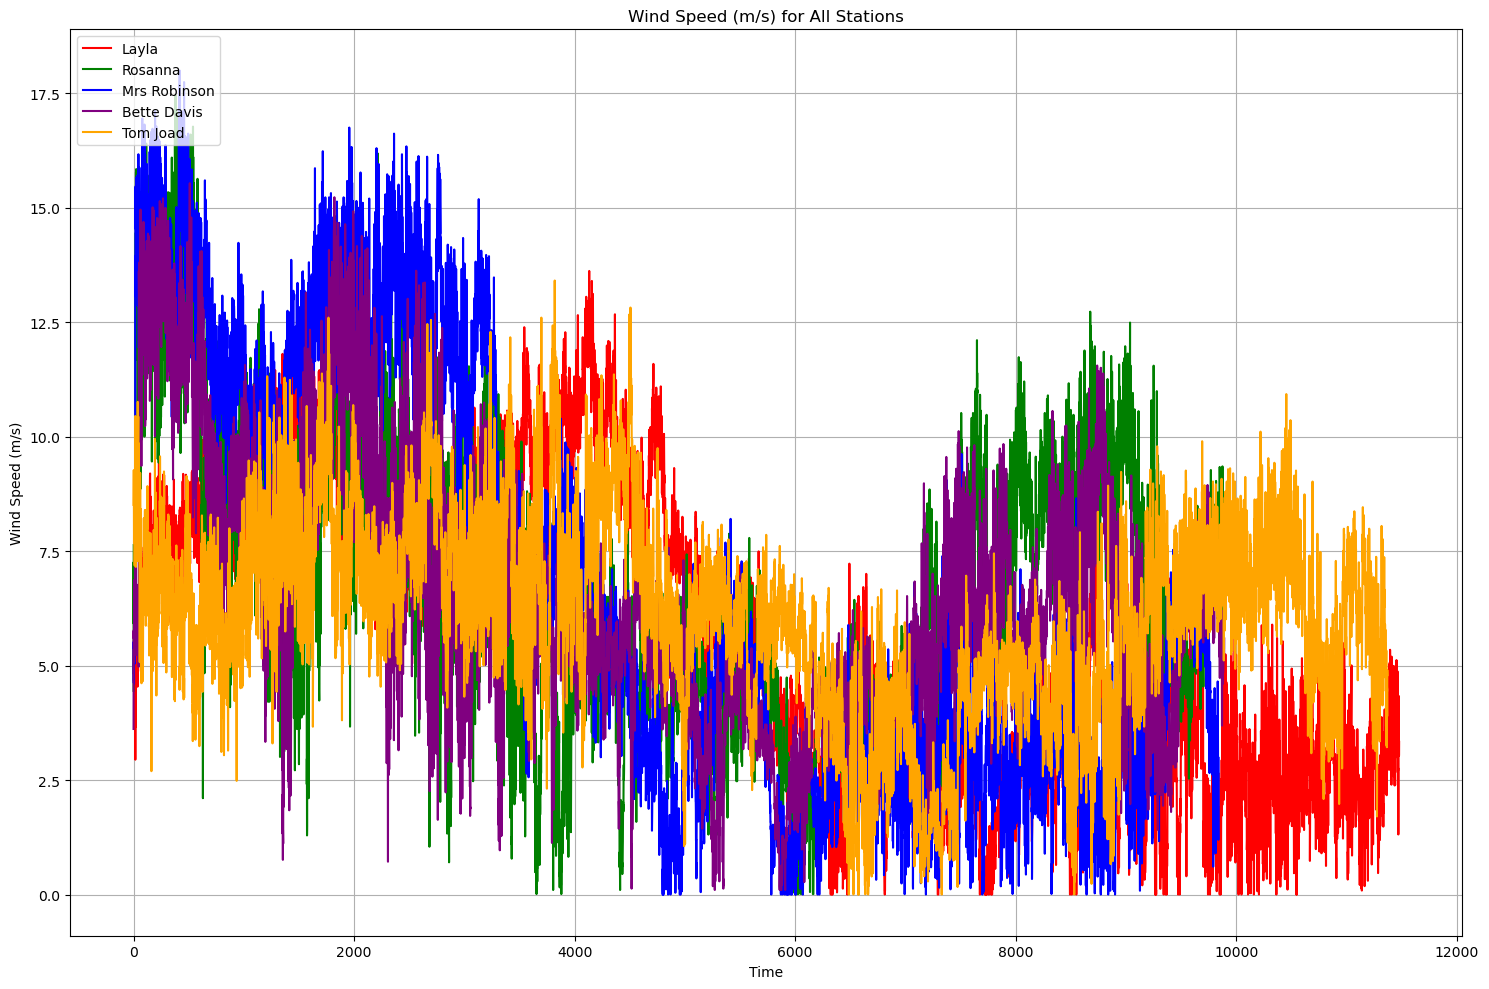

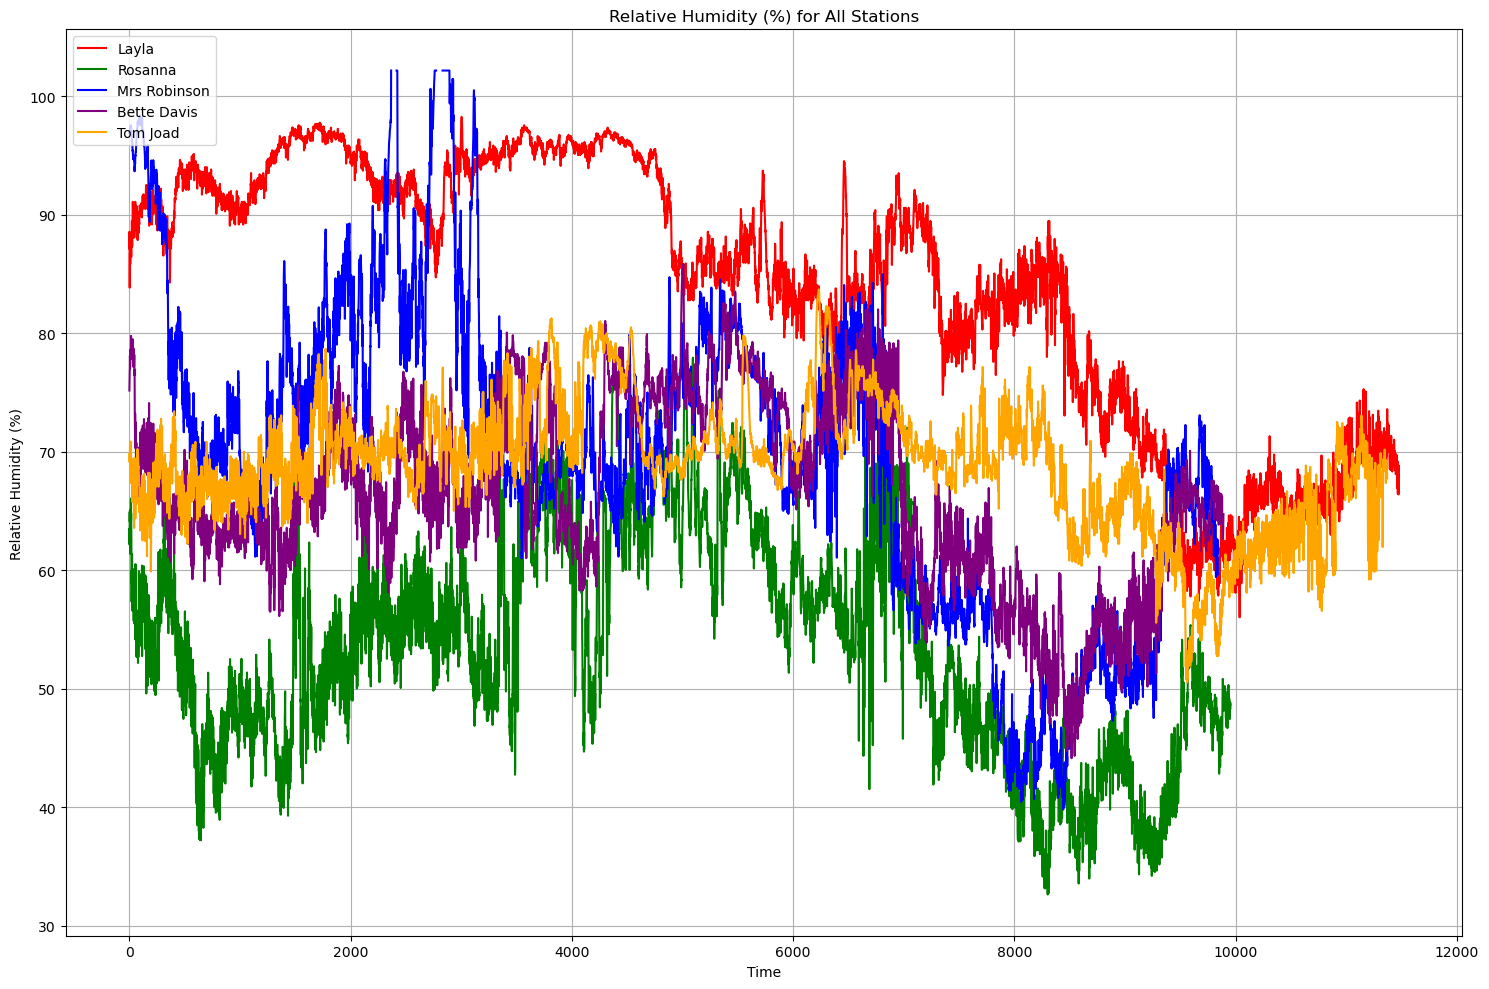

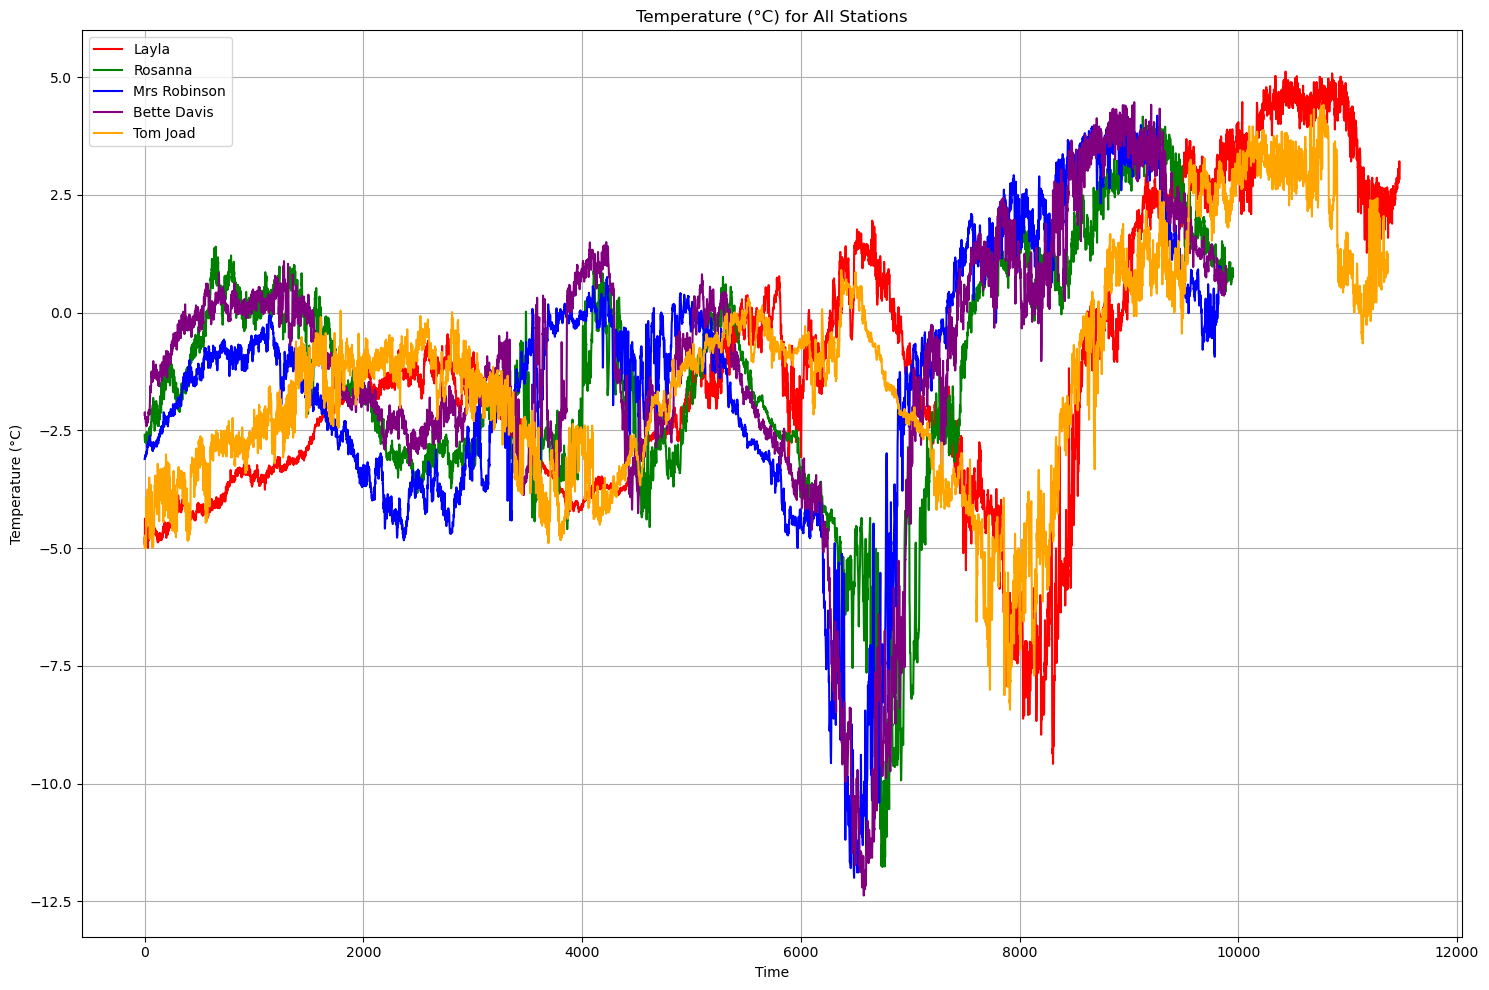

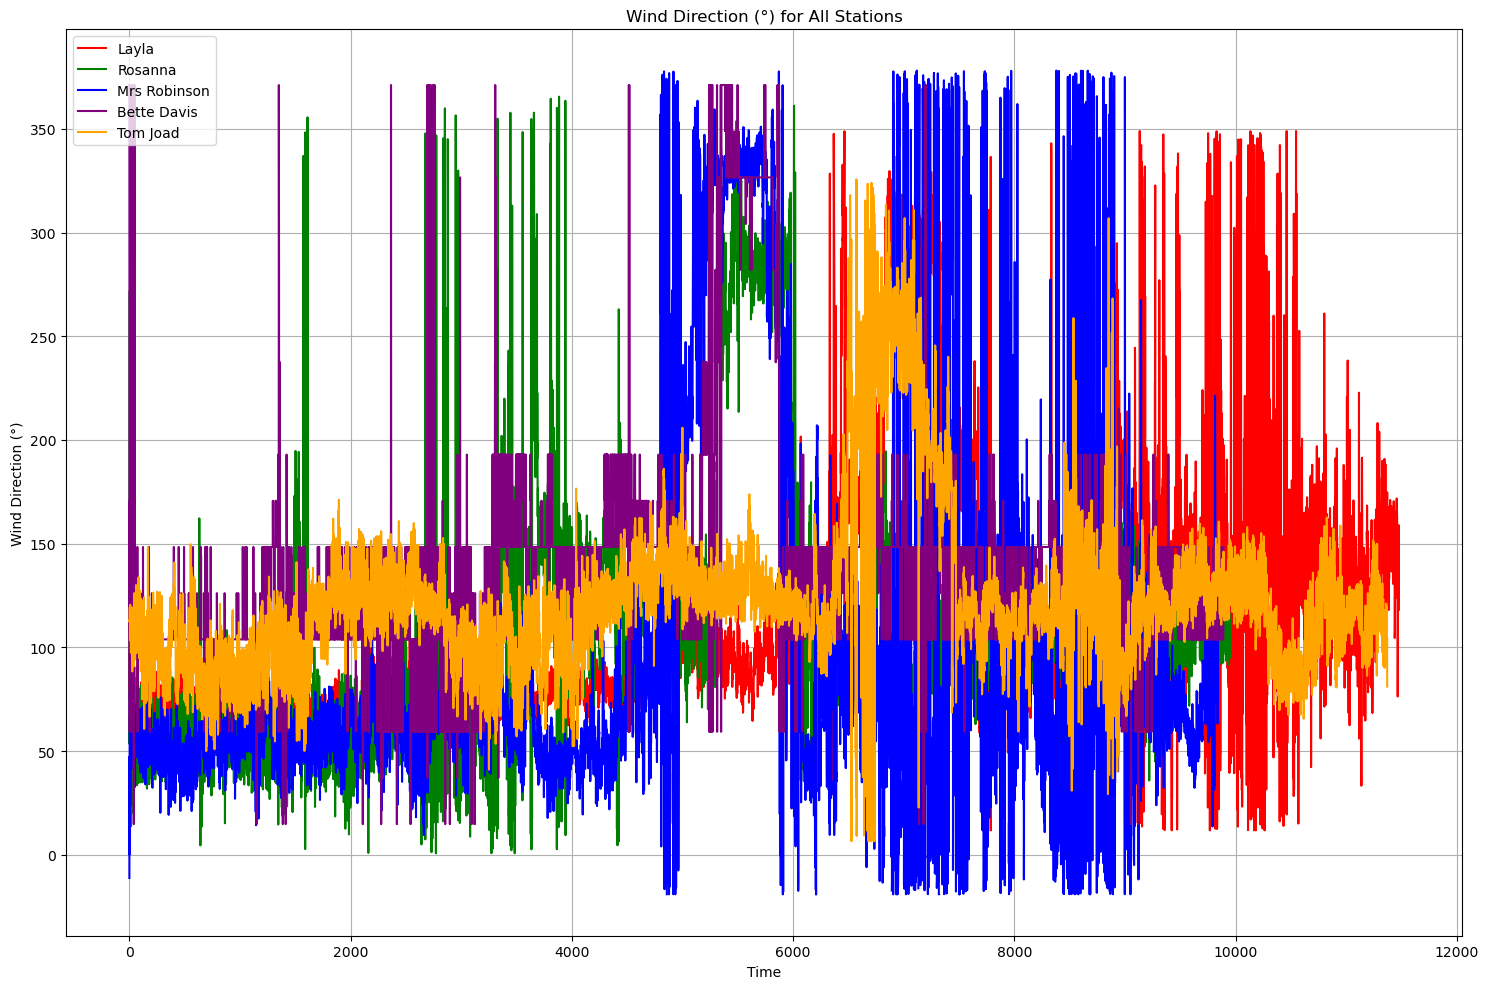

KeyError: 'calibrated_air_pressure'

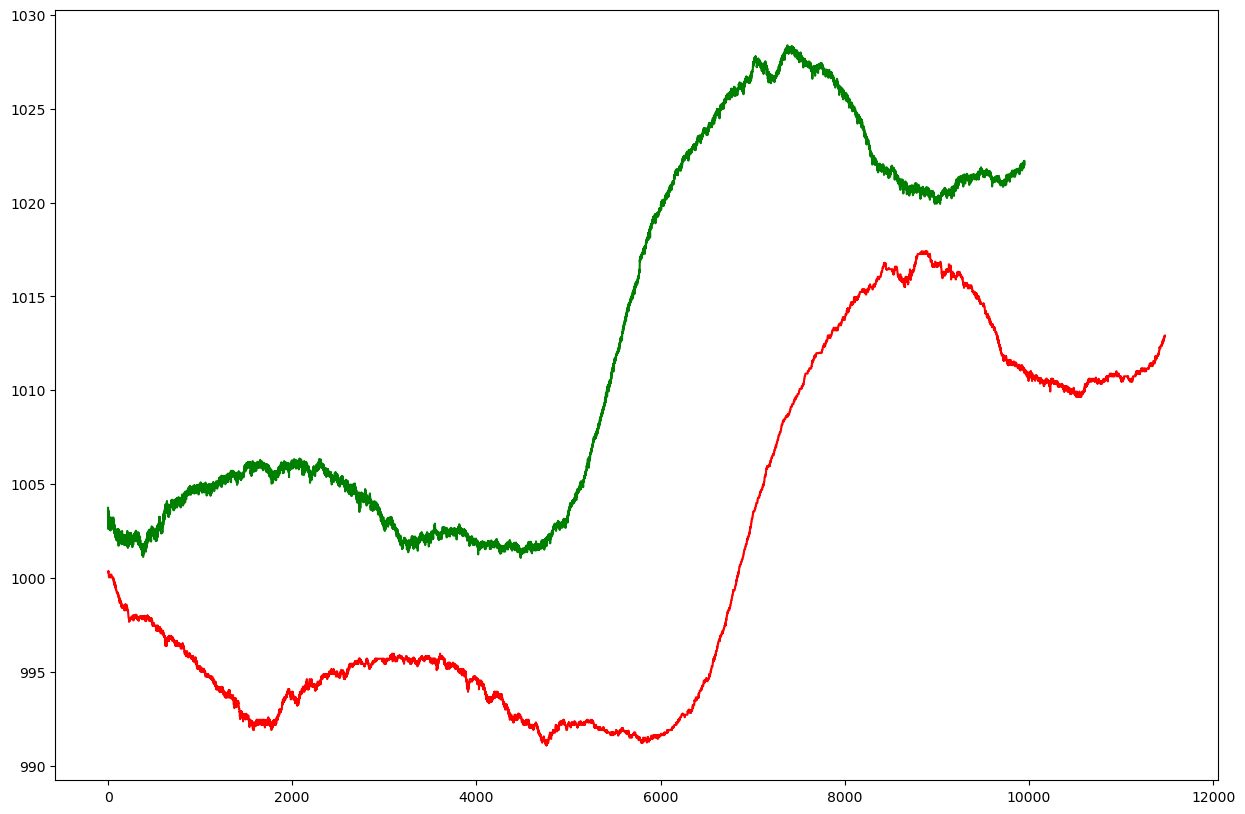

In [ ]:
# import matplotlib.pyplot as plt

# # Erstelle einen Plot für die Windgeschwindigkeit (calibrated_wind_speed)
# plt.figure(figsize=(15, 10))
# plt.plot(layla_filtered_df.index, layla_filtered_df['calibrated_wind_speed'], label='Layla', color='red')
# plt.plot(rosanna_filtered_df.index, rosanna_filtered_df['calibrated_wind_speed'], label='Rosanna', color='green')
# plt.plot(mrsrobinson_filtered_df.index, mrsrobinson_filtered_df['calibrated_wind_speed'], label='Mrs Robinson', color='blue')
# plt.plot(bettedavis_filtered_df.index, bettedavis_filtered_df['calibrated_wind_speed'], label='Bette Davis', color='purple')
# plt.plot(tomjoad_filtered_df.index, tomjoad_filtered_df['calibrated_wind_speed'], label='Tom Joad', color='orange')
# plt.title('Wind Speed (m/s) for All Stations')
# plt.xlabel('Time')
# plt.ylabel('Wind Speed (m/s)')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Erstelle einen Plot für die relative Luftfeuchtigkeit (calibrated_rel_humidity)
# plt.figure(figsize=(15, 10))
# plt.plot(layla_filtered_df.index, layla_filtered_df['calibrated_rel_humidity'], label='Layla', color='red')
# plt.plot(rosanna_filtered_df.index, rosanna_filtered_df['calibrated_rel_humidity'], label='Rosanna', color='green')
# plt.plot(mrsrobinson_filtered_df.index, mrsrobinson_filtered_df['calibrated_rel_humidity'], label='Mrs Robinson', color='blue')
# plt.plot(bettedavis_filtered_df.index, bettedavis_filtered_df['calibrated_rel_humidity'], label='Bette Davis', color='purple')
# plt.plot(tomjoad_filtered_df.index, tomjoad_filtered_df['calibrated_rel_humidity'], label='Tom Joad', color='orange')
# plt.title('Relative Humidity (%) for All Stations')
# plt.xlabel('Time')
# plt.ylabel('Relative Humidity (%)')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Erstelle einen Plot für die Temperatur (temperature)
# plt.figure(figsize=(15, 10))
# plt.plot(layla_filtered_df.index, layla_filtered_df['temperature'], label='Layla', color='red')
# plt.plot(rosanna_filtered_df.index, rosanna_filtered_df['temperature'], label='Rosanna', color='green')
# plt.plot(mrsrobinson_filtered_df.index, mrsrobinson_filtered_df['temperature'], label='Mrs Robinson', color='blue')
# plt.plot(bettedavis_filtered_df.index, bettedavis_filtered_df['temperature'], label='Bette Davis', color='purple')
# plt.plot(tomjoad_filtered_df.index, tomjoad_filtered_df['temperature'], label='Tom Joad', color='orange')
# plt.title('Temperature (°C) for All Stations')
# plt.xlabel('Time')
# plt.ylabel('Temperature (°C)')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Erstelle einen Plot für die Windrichtung (wind_direction)
# plt.figure(figsize=(15, 10))
# plt.plot(layla_filtered_df.index, layla_filtered_df['wind_direction'], label='Layla', color='red')
# plt.plot(rosanna_filtered_df.index, rosanna_filtered_df['wind_direction'], label='Rosanna', color='green')
# plt.plot(mrsrobinson_filtered_df.index, mrsrobinson_filtered_df['wind_direction'], label='Mrs Robinson', color='blue')
# plt.plot(bettedavis_filtered_df.index, bettedavis_filtered_df['wind_direction'], label='Bette Davis', color='purple')
# plt.plot(tomjoad_filtered_df.index, tomjoad_filtered_df['wind_direction'], label='Tom Joad', color='orange')
# plt.title('Wind Direction (°) for All Stations')
# plt.xlabel('Time')
# plt.ylabel('Wind Direction (°)')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Erstelle einen Plot für den Luftdruck (calibrated_air_pressure)
# plt.figure(figsize=(15, 10))
# plt.plot(layla_filtered_df.index, layla_filtered_df['calibrated_air_pressure'], label='Layla', color='red')
# plt.plot(rosanna_filtered_df.index, rosanna_filtered_df['calibrated_air_pressure'], label='Rosanna', color='green')
# plt.plot(mrsrobinson_filtered_df.index, mrsrobinson_filtered_df['calibrated_air_pressure'], label='Mrs Robinson', color='blue')
# plt.plot(bettedavis_filtered_df.index, bettedavis_filtered_df['calibrated_air_pressure'], label='Bette Davis', color='purple')
# plt.plot(tomjoad_filtered_df.index, tomjoad_filtered_df['calibrated_air_pressure'], label='Tom Joad', color='orange')
# plt.title('Air Pressure (hPa) for All Stations')
# plt.xlabel('Time')
# plt.ylabel('Air Pressure (hPa)')
# plt.legend(loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()
